In [1]:
import numpy as np
import matplotlib.pyplot as plt
from RateDistortion import *
from ProgressBar import ProgressBar
from scipy.linalg import inv,pinv,null_space

In [2]:
R = np.array([[2,0,1],[0,2,1]])
R2 = np.vstack((R,np.array([0.5,0.5,2])))
s = np.array([[0.8,0.2],[0.2,0.8]])
px = np.array([0.2,0.3,0.5])

In [3]:
Qinv = np.diag(pinv(R) @ np.ones(np.shape(R)[0]))
Q = inv(Qinv)
#tolerance = 1e-9

Dxy = getFullDistortionFunction(R,s)
result = getRD(px,Dxy,numPoints=400,show_pb=True)

In [4]:
# line for the bound
dmin = np.min(result['Dmax_v'])
dmax = np.max(result['Dmax_v'])
L = getAvgLambdaStar(Q,px)
D_v = np.array([dmin,dmax])
B_v = hx(px) - D_v - L

# null space vector
v = null_space(R)[:,0]


# find the range over which adding a constant times v still gives a valid probability
a = pinv(R) @ np.ones(2)
b = v

vmin = -1*a/b
vmax = (1-a)/b
for i in range(len(vmin)):
  if v[i] < 0:
    foo = vmin[i]
    vmin[i] = vmax[i]
    vmax[i] = foo

rv = [np.max(vmin),np.min(vmax)]

# For what vector in the null space is $\Lambda^*$ minimized?

epsilon = 1e-3
bump_v = np.linspace(rv[0]+epsilon,rv[1]-epsilon,1000000)

Lmin = None

#linecount = 0
for bump in bump_v:
  Qinv = np.diag(pinv(R) @ np.ones(np.shape(R)[0]) + bump * v)
  Q = inv(Qinv)
  L = getAvgLambdaStar(Q,px)
  #D_v2 = np.array([dmin,dmax])
  #B_v2 = hx(px) - D_v - L
  
  if (Lmin == None) or (Lmin['L'] > L):
    Lmin = {'L':L,'Qinv':Qinv,'bump':bump}
    #print(Lmin)

B_v2 = hx(px) - D_v - Lmin['L']

In [5]:
# find point of equality for R and s
T = s @ R @ Lmin['Qinv']
py = px @ pinv(T)
pxy = np.diag(py) @ T
eq = [np.sum(pxy * Dxy),MI(pxy)]

In [6]:
qqq = 0.5
s2 = np.hstack((s * qqq,np.array([[1-qqq],[1-qqq]])))

dxy2 = getFullDistortionFunction(R2,s2)
r2 = getRD(px,dxy2)

In [7]:
# find point of equality for R2 and s2
B = R2 @ np.diag(inv(R2) @ np.ones(3))
T2 = s2 @ B
py2 = px @ pinv(T2)
pxy2 = np.diag(py2) @ T2
eq2 = [np.sum(pxy2 * dxy2),MI(pxy2)]


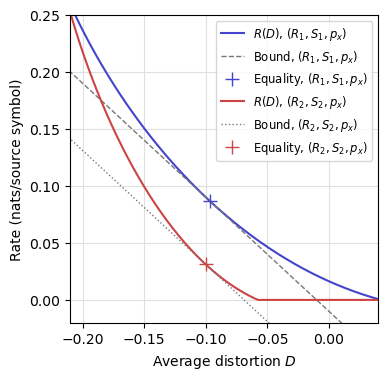

In [8]:
plt.plot(result['Dmax_v'],result['r_v'],color='#4444cc',linestyle='-',label='$R(D)$, $(R_1,S_1,p_x)$')

#B_v2 = hx(px) - D_v - Lmin['L']
plt.plot(D_v,B_v2,color='#777777',linewidth=1,linestyle='--',label='Bound, $(R_1,S_1,p_x)$')

plt.plot([eq[0]],[eq[1]],marker='+',color='#4444cc',markersize=10,linestyle='',label='Equality, $(R_1,S_1,p_x)$')

Qinv = np.diag(pinv(R2) @ np.ones(3))
Q = inv(Qinv)
LL = getAvgLambdaStar(Q,px)
B_v3 = hx(px) - D_v - LL

plt.plot(r2['Dmax_v'],r2['r_v'],color='#cc4444',linestyle='-',label='$R(D)$, $(R_2,S_2,p_x)$')
plt.plot(D_v,B_v3,color='#777777',linewidth=1,linestyle=':',label='Bound, $(R_2,S_2,p_x)$')

plt.plot([eq2[0]],[eq2[1]],marker='+',color='#cc4444',markersize=10,linestyle='',label='Equality, $(R_2,S_2,p_x)$')

plt.gcf().set_size_inches((4,4))
plt.legend(fontsize='small')
plt.xlabel('Average distortion $D$')
plt.ylabel('Rate (nats/source symbol)')

plt.axis([-0.21,0.04,-0.02,0.25])

plt.gca().set_aspect(1/plt.gca().get_data_ratio())
plt.gca().grid(visible=True,color='#e0e0e0')

plt.savefig('Figure5.pdf',bbox_inches='tight')